In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats
from statsmodels.stats.power import TTestIndPower
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Data Preprocessing

In [2]:
def cleanup(data):
    fields = data.strip().split(',')
    fields = [field.strip('"').replace('\\', '').replace('{', '').replace('}', '').replace("'", '').replace("[", '').replace("]", '').replace('"', '') for field in fields]
    return fields

In [3]:
def parseCSV(filepath):
    processed_data = []

    with open(filepath, 'r', encoding='utf-8') as file:
        for i,subj_data in enumerate(file):

            if i==0: continue # CSV headers

            processed_subj = cleanup(subj_data)

            subject_info = {
                'timestamp': processed_subj[4]
                }

            img_responses = []
            post_survey = {}
            resp = None

            for item in processed_subj[5:]:
                if ':' in item:
                    key, value = item.split(':', 1)

                    if key == 'response':
                        resp = value
                    elif key == 'image_name':
                        subject_info[os.path.basename(value)] = resp
                    else:
                        post_survey[key] = value

                # If subjects include newline character in post-survey comments
                else:
                    value = item
                    if resp and resp in post_survey:
                        post_survey[last_key] += ' ' + value

            subject_info.update(post_survey)
            processed_data.append(subject_info)

        df = pd.DataFrame(processed_data)
        return df

In [4]:
def filter_subjects(df, attentioncheck):
    """
    Filter out subjects from the DataFrame based on the attention check. 
    Also filters out test runs of the experiment (labeled 'TEST' in post-survey comments). 
    If attentioncheck is true, filter based on attention check; otherwise, just remove test runs. 
    """

    df['agents'] = pd.to_numeric(df['agents'], errors='coerce')
    df['plates'] = pd.to_numeric(df['plates'], errors='coerce')
    if attentioncheck:
        filtered_df = df[(df['plates'] == 3) & (~df['comments'].str.contains("TEST", na=False))] 
    else:
        filtered_df = df[(~df['comments'].str.contains("TEST", na=False))]
    return filtered_df

In [5]:
filepath = '../rawdata/anon_expt2.csv'
df = parseCSV(filepath)
filtered_df = filter_subjects(df, attentioncheck=True)

# Building & fitting the mixed linear model

In [6]:
def effect_code_workload(image_name):
    parts = image_name.split('_')
    workload = parts[2] 
    if workload == '1':
        return [1, 0]
    elif workload == '4':
        return [0, 0]
    elif workload == '8':
        return [0, 1]
    else:
        return [None, None]

def effect_code_bottleneck(image_name):
    if ('_1.png' in image_name):
        return 0
    elif ('_6.png' in image_name):
        return 1
    else:
        return None

def effect_code_groupsize(image_name):
    if 'cartoon_2' in image_name:
        return [1, 0]
    elif 'cartoon_4' in image_name:
        return [0, 0]
    elif 'cartoon_6' in image_name:
        return [0, 1]
    else:
        return [None, None]

def decode_categories(row):
    if row['x_1_1'] == 1 and row['x_1_2'] == 0:
        row['workload'] = '1'
    elif row['x_1_1'] == 0 and row['x_1_2'] == 1:
        row['workload'] = '8'
    elif row['x_1_1'] == 0 and row['x_1_2'] == 0:
        row['workload'] = '4'

    row['bottleneck'] = 'High' if row['x_3'] == 1 else 'Low'

    if row['x_2_1'] == 1 and row['x_2_2'] == 0:
        row['group_size'] = '2'
    elif row['x_2_1'] == 0 and row['x_2_2'] == 1:
        row['group_size'] = '6'
    elif row['x_2_1'] == 0 and row['x_2_2'] == 0:
        row['group_size'] = '4'

    return row

In [8]:
image_columns = [col for col in filtered_df.columns if col.endswith('.png')]
long_df = pd.melt(filtered_df, id_vars=['timestamp'], value_vars=image_columns, var_name='image', value_name='resp')

# Apply the effect coding functions
long_df[['x_1_1', 'x_1_2']] = pd.DataFrame(long_df['image'].apply(effect_code_workload).tolist(), index=long_df.index)
long_df[['x_2_1', 'x_2_2']] = pd.DataFrame(long_df['image'].apply(effect_code_groupsize).tolist(), index=long_df.index)
long_df[['x_3']] = pd.DataFrame(long_df['image'].apply(effect_code_bottleneck).tolist(), index=long_df.index)

long_df = long_df.dropna(subset=['x_3', 'x_2_1', 'x_2_2', 'x_1_1', 'x_1_2'])
long_df['response'] = pd.to_numeric(long_df['resp'], errors='coerce')
long_df = long_df.dropna(subset=['response'])

model = smf.mixedlm("response ~ x_1_1 + x_1_2 + x_2_1 + x_2_2 + x_3 + x_1_1:x_2_1 + x_1_1:x_2_2 + x_1_2:x_2_1 + x_1_2:x_2_2 + x_2_1:x_3 + x_2_2:x_3 + x_1_1:x_3 + x_1_2:x_3", long_df, groups=long_df["timestamp"])
result = model.fit()

print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: response   
No. Observations: 9643    Method:             REML       
No. Groups:       270     Scale:              4.0126     
Min. group size:  22      Log-Likelihood:     -20839.3923
Max. group size:  72      Converged:          Yes        
Mean group size:  35.7                                   
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      5.815    0.128  45.453 0.000  5.565  6.066
x_1_1          1.430    0.100  14.299 0.000  1.234  1.626
x_1_2         -0.230    0.100  -2.301 0.021 -0.426 -0.034
x_2_1         -1.301    0.100 -13.003 0.000 -1.497 -1.105
x_2_2          0.624    0.100   6.233 0.000  0.428  0.820
x_3           -0.732    0.091  -8.021 0.000 -0.911 -0.553
x_1_1:x_2_1    0.226    0.122   1.844 0.065 -0.014  0.466
x_1_1:x_2_2   -0.329    

# Visualizing subject responses

/var/folders/rp/drddpy_10vd_hlk0_w76l5_w0000gn/T/ipykernel_54622/4206204515.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby('group_size')['response'].mean()
/var/folders/rp/drddpy_10vd_hlk0_w76l5_w0000gn/T/ipykernel_54622/4206204515.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = subset.groupby('group_size')['response'].apply(standard_error)


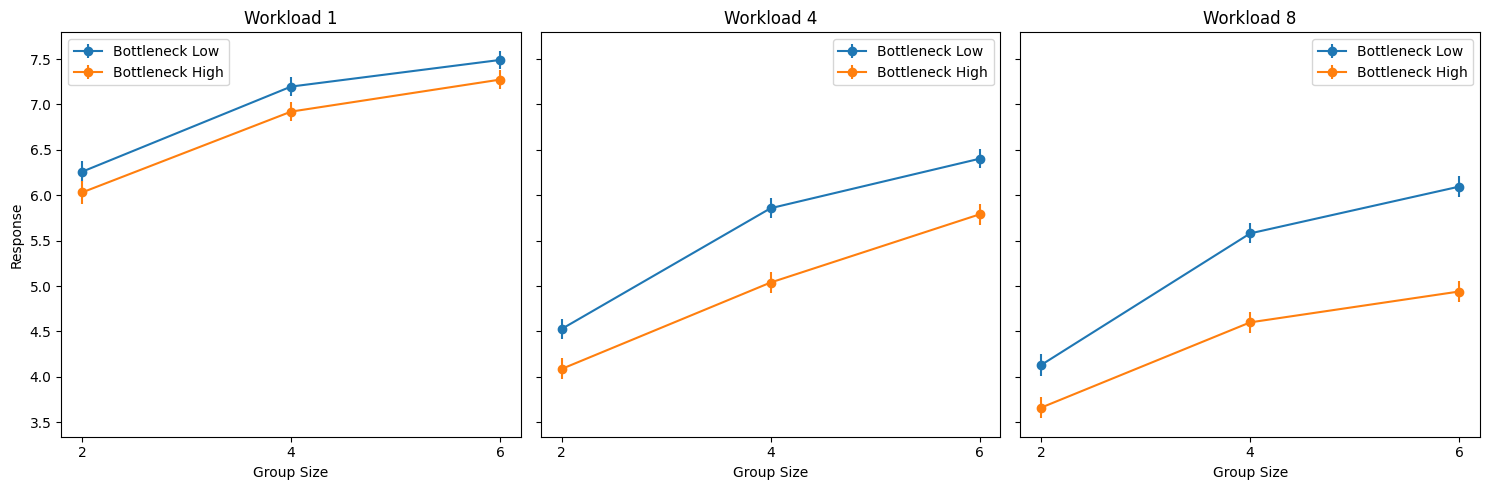

In [9]:
groupcoding = [
    (long_df['x_2_1'] == 1) & (long_df['x_2_2'] == 0), 
    (long_df['x_2_1'] == 0) & (long_df['x_2_2'] == 0), 
    (long_df['x_2_1'] == 0) & (long_df['x_2_2'] == 1) 
]

workloadcoding = [
    (long_df['x_1_1'] == 1) & (long_df['x_1_2'] == 0), 
    (long_df['x_1_1'] == 0) & (long_df['x_1_2'] == 0), 
    (long_df['x_1_1'] == 0) & (long_df['x_1_2'] == 1) 
]

bottleneckcoding = [
    (long_df['x_3'] == 0),
    (long_df['x_3'] == 1)
]

long_df['GroupSize'] = np.select(groupcoding, [2,4,6], default=np.nan)
long_df['Workload'] = np.select(workloadcoding, [1,4,8], default=np.nan)
long_df['Bottleneck'] = np.select(bottleneckcoding, [1,6], default=np.nan)

long_df = long_df.apply(decode_categories, axis=1)
long_df['group_size'] = pd.Categorical(long_df['group_size'], categories=['2', '4', '6'], ordered=True)
long_df['workload'] = pd.Categorical(long_df['workload'], categories=['1', '4', '8'], ordered=True)

def standard_error(data):
    return scipy.stats.sem(data)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

workloads = ['1', '4', '8']

for i, (workload, ax) in enumerate(zip(workloads, axes.flatten())):
    for bottleneck in ['Low', 'High']:
        subset = long_df[(long_df['workload'] == workload) & (long_df['bottleneck'] == bottleneck)]
        means = subset.groupby('group_size')['response'].mean()
        sems = subset.groupby('group_size')['response'].apply(standard_error)
        ax.errorbar(means.index, means, yerr=sems, label=f'Bottleneck {bottleneck}', fmt='-o')

    ax.set_title(f'Workload {workload}')
    ax.set_xlabel('Group Size')
    ax.legend()

axes[0].set_ylabel('Response')
plt.tight_layout()
plt.show()